In [50]:
from tsai.all import *
import logging
import matplotlib.pyplot as plt
import zarr
import sklearn.metrics as skm
import seaborn as sns
import copy

In [51]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
%matplotlib inline

In [52]:
#Size of data
valid_size = 0.2
test_size = 0.05
str_size_of_data = 'valid_size_' + str(valid_size).replace(".","_") + 'test_size_' + str(test_size).replace(".","_")
#dates
file_data = '07_05'
#Problem to solve
problem = "Multiclass"

# time resolution
# example 0.001 s -> 0.002 s 
resolution = 0.01
batch_size = 2
str_resolution = 'resolution_' + str(resolution).replace(".","_")

file_for_train_data = 'train_data_' + file_data
file_for_train_data_x = file_for_train_data + '_x'
file_for_train_data_y = file_for_train_data + '_y'
folder_to_save_base = 'models_data_split' + '/' + problem + '/' + str_size_of_data + '/' + str_resolution
#learning cycles:
cycles = 4

In [53]:


# Define models to train
models = [
    {
        'name': 'LSTM', 
        'model': LSTM, 
        'params': [
            {'hidden_size': 100, 'bidirectional': True},
            {'hidden_size': 1000, 'bidirectional': True},
        ]
    },
    {
        'name': 'LSTM_FCN', 
        'model': LSTM_FCN, 
        'params': [
            {'hidden_size': 100, 'bidirectional': True},
            {'hidden_size': 1000, 'bidirectional': True},
        ]
    },
    {
        'name': 'FCNPlus', 
        'model': FCNPlus, 
        'params': [
            {'fc_dropout': .6},
            {'fc_dropout': .3},
        ]
    },
    {
        'name': 'TST', 
        'model': TST, 
        'params': [
            {'hidden_size': 100, 'dropout': .3},
            {'hidden_size': 1000, 'dropout': .1, 'fc_dropout': .8},
        ]
    },
]



In [54]:
class one_model_of_multiple:
    def __init__(self, model_name, X, Y, resolution, batch_size,
                 valid_size, test_size, **params):
        self.model_name = model_name
        self.Y = Y
        self.X = X
        self.resolution = resolution
        self.valid_size = valid_size
        self.test_size = test_size
        self.stage = 0
        self.batch_size = batch_size
        self.params = params

        self.encode_one_host()
        self.create_numpy_arrays()
        self.create_zarr_arrays()
        self.create_splits()
        self.create_dlses()

        if self.model_name == "LSTM":
            self.model_tooth = LSTM(self.dls_tooth.vars, self.dls_tooth.c, **params)
            self.model_shaft = LSTM(self.dls_shaft.vars, self.dls_shaft.c, **params)
            self.model_drift = LSTM(self.dls_drift.vars, self.dls_drift.c, **params)
        
        elif self.model_name == "LSTM_FCN":
            self.model_tooth = LSTM_FCN(self.dls_tooth.vars, self.dls_tooth.c, seq_len=self.X_zarr.shape[-1], **params)
            self.model_shaft = LSTM_FCN(self.dls_shaft.vars, self.dls_shaft.c, seq_len=self.X_zarr.shape[-1], **params)
            self.model_drift = LSTM_FCN(self.dls_drift.vars, self.dls_drift.c, seq_len=self.X_zarr.shape[-1], **params)
        
        elif model_name == "FCNPlus":
            self.model_tooth = FCNPlus(self.dls_tooth.vars, self.dls_tooth.c, **params)
            self.model_shaft = FCNPlus(self.dls_tooth.vars, self.dls_tooth.c, **params)
            self.model_drift = FCNPlus(self.dls_drift.vars, self.dls_drift.c, **params)
        
        elif model_name == "TST":
            self.model_tooth = TST(self.dls_tooth.vars, self.dls_tooth.c, self.dls_tooth.len, **params)
            self.model_shaft = TST(self.dls_shaft.vars, self.dls_shaft.c, self.dls_shaft.len, **params)
            self.model_drift = TST(self.dls_drift.vars, self.dls_drift.c, self.dls_drift.len, **params)
        
        else:
            raise Exception("Error: Provided bad model name")

        
        logger.info("Initialize learners")
        self.learn_tooth = Learner(self.dls_tooth, self.model_tooth, metrics=accuracy, cbs=ShowGraph(plot_metrics=False))
        self.learn_shaft = Learner(self.dls_shaft, self.model_shaft, metrics=accuracy, cbs=ShowGraph(plot_metrics=False))
        self.learn_drift = Learner(self.dls_drift, self.model_drift, metrics=accuracy, cbs=ShowGraph(plot_metrics=False))
        
        logger.info("Save learner as stage0")
        self.learn_tooth.save('stage' + str(self.stage))
        self.learn_shaft.save('stage' + str(self.stage))
        self.learn_drift.save('stage' + str(self.stage))
        self.stage += 1


        # self.model

    @staticmethod
    def one_hot_encoder(y):
        #[ząb przekładni, wał, dryft]
        return{
            0:[0,0,0],
            1:[0,0,1],
            2:[0,1,0],
            3:[0,1,1],
            4:[1,0,0],
            5:[1,0,1],
            6:[1,1,0],
            7:[1,1,1]
        }[y]

    @staticmethod
    def one_hot_decoder(y):
        #[ząb przekładni, wał, dryft]
        return{
            tuple([0,0,0]):0,
            tuple([0,0,1]):1,
            tuple([0,1,0]):2,
            tuple([0,1,1]):3,
            tuple([1,0,0]):4,
            tuple([1,0,1]):5,
            tuple([1,1,0]):6,
            tuple([1,1,1]):7
        }[y]

    def encode_one_host(self):
        self.Y_fault_tooth = []
        self.Y_fault_shaft = []
        self.Y_fault_drift = []
        for y in self.Y:
            (tooth, shaft, drift) = self.one_hot_encoder(y)
            self.Y_fault_tooth.append(tooth)
            self.Y_fault_shaft.append(shaft)
            self.Y_fault_drift.append(drift)


    def create_numpy_arrays(self):
        logger.info("Create numpy array with X and Y")
        self.X_numpy = np.array(self.X)
        self.X_numpy_vibration = np.array(self.X)    

        self.Y_numpy_tooth = np.array(self.Y_fault_tooth)
        self.Y_numpy_shaft = np.array(self.Y_fault_shaft)
        self.Y_numpy_drift = np.array(self.Y_fault_drift)

        # logger.info("Sample X for every 100 samples")
        # to take with resolution defined before:
        samples_to_take = self.resolution * 1000
        self.X_numpy = self.X_numpy[:, :2, :: int(samples_to_take)]
        self.X_numpy_vibration = self.X_numpy_vibration[:, 0, :: int(samples_to_take)]

    def create_zarr_arrays(self):
        logger.info("Create zarr array's with X and Y")
        path = Path('data')
        if not os.path.exists(path): os.makedirs(path)
        
        self.X_zarr = zarr.open(path/'X_zarr.zarr', mode='w', shape=self.X_numpy.shape, dtype=self.X_numpy.dtype, chunks=(1, -1, -1))
        self.X_zarr[:] = self.X_numpy
        self.X_zarr_vibration = zarr.open(path/'X_zarr_vibration.zarr', mode='w', shape=self.X_numpy_vibration.shape, dtype=self.X_numpy_vibration.dtype, chunks=(1, -1))
        self.X_zarr_vibration[:] = self.X_numpy_vibration
        print(self.X_zarr_vibration[0,:10])
        

        self.X_zarr = zarr.open(path/'X_zarr.zarr', mode='r')
        self.X_zarr_vibration = zarr.open(path/'X_zarr_vibration.zarr', mode='r')

        print("all:" + str(self.X_zarr.shape))
        print("vibration:" + str(self.X_zarr_vibration.shape))
        
        self.Y_zarr_tooth = zarr.open(path/'y_zarr_tooth.zarr', mode='w', shape=self.Y_numpy_tooth.shape, dtype=self.Y_numpy_tooth.dtype, chunks=False) # y data is small and don't need to be chunked
        self.Y_zarr_shaft = zarr.open(path/'y_zarr_shaft.zarr', mode='w', shape=self.Y_numpy_shaft.shape, dtype=self.Y_numpy_shaft.dtype, chunks=False) # y data is small and don't need to be chunked
        self.Y_zarr_drift = zarr.open(path/'y_zarr_drift.zarr', mode='w', shape=self.Y_numpy_drift.shape, dtype=self.Y_numpy_drift.dtype, chunks=False) # y data is small and don't need to be chunked
        
        self.Y_zarr_tooth[:] = self.Y_numpy_tooth
        self.Y_zarr_shaft[:] = self.Y_numpy_shaft
        self.Y_zarr_drift[:] = self.Y_numpy_drift

        logger.info("Y_zarr:_drift")
        logger.info(self.Y_zarr_drift[0])

    def create_splits(self):
        logger.info("Create splits")
        train_only = False  # set to True for debugging (valid = train)
        stratify = True
        balance = False
        shuffle = True
        predefined_splits = None
        show_plot = False 


        check_splits = True
        random_state = 23
        logger.info("Split data to train and valid")
        #Set show plot to True if you want to see split, but this stops main thread
        self.splits = get_splits(self.X_numpy, valid_size=self.valid_size, test_size=test_size, shuffle=shuffle, balance=balance, stratify=stratify,
                            train_only=train_only, check_splits=check_splits, random_state=random_state, show_plot=show_plot, verbose=True)
        self.splits_vibration = get_splits(self.X_numpy_vibration, valid_size=self.valid_size, test_size=test_size, shuffle=shuffle, balance=balance, stratify=stratify, train_only=train_only, check_splits=check_splits, random_state=random_state, show_plot=show_plot, verbose=True)

    def create_dlses(self):
        logger.info("Create dlses")
        tfms  = [None, TSClassification()] # TSClassification == Categorize
        batch_tfms = TSStandardize(by_var=True)
        tfms_vibration  = [None, TSClassification()] # TSClassification == Categorize
        batch_tfms_vibration = TSStandardize(by_var=True)
        self.dls_tooth = get_ts_dls(self.X_numpy, self.Y_numpy_tooth, splits=self.splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=self.batch_size, num_workers=12) 
        self.dls_shaft = get_ts_dls(self.X_numpy, self.Y_numpy_shaft, splits=self.splits, tfms=tfms_vibration, batch_tfms=batch_tfms_vibration, inplace=False, bs=self.batch_size, num_workers=12) 
        self.dls_drift = get_ts_dls(self.X_numpy, self.Y_numpy_drift, splits=self.splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=self.batch_size, num_workers=12) 
        # num_workers = 1 *cpus

    def fit_one_cycle(self, cycle=300):
        logger.info(f"Feet {cycle} cycles shaft")
        self.learn_shaft.fit_one_cycle(cycle, lr_max=1e-3)
        logger.info(f"Feet {cycle} cycles tooth")
        self.learn_tooth.fit_one_cycle(cycle, lr_max=1e-3)
        logger.info(f"Feet {cycle} cycles drift")
        self.learn_drift.fit_one_cycle(cycle, lr_max=1e-3)

        logger.info("Save learners as stage1")
        self.learn_tooth.save('stage' + str(self.stage))
        self.learn_shaft.save('stage' + str(self.stage))
        self.learn_drift.save('stage' + str(self.stage))
        self.stage += 1

        logger.info(f"Tooth plot metrics, model: {self.model_name}")
        self.learn_tooth.recorder.plot_metrics()
        logger.info(f"Shaft plot metrics, model: {self.model_name}")
        self.learn_shaft.recorder.plot_metrics()
        logger.info(f"Drift plot metrics, model: {self.model_name}")
        self.learn_drift.recorder.plot_metrics()

        logger.info(f"Confusion matrixes for each model")
        self.plot_confusion_matrixes_for_valid()
    
    def plot_confusion_matrixes_for_valid(self):
        self.interp_tooth = ClassificationInterpretation.from_learner(self.learn_tooth)
        self.interp_shaft = ClassificationInterpretation.from_learner(self.learn_shaft)
        self.interp_drift = ClassificationInterpretation.from_learner(self.learn_drift)
        
        self.interp_tooth.plot_confusion_matrix(title=f"Confusion matrix tooth model: {self.model_name}, {self.params}")
        plt.show()
        self.interp_shaft.plot_confusion_matrix(title=f"Confusion matrix shaft model: {self.model_name}, {self.params}")
        plt.show()
        self.interp_drift.plot_confusion_matrix(title=f"Confusion matrix drift model: {self.model_name}, {self.params}")
        plt.show()

    def save_all(self, folder_to_save):
        self.learn_tooth.save_all(path=folder_to_save, dls_fname='dls', model_fname='model', learner_fname='learner_tooth')
        self.learn_shaft.save_all(path=folder_to_save, dls_fname='dls', model_fname='model', learner_fname='learner_shaft')
        self.learn_drift.save_all(path=folder_to_save, dls_fname='dls', model_fname='model', learner_fname='learner_drift')
    
    def get_preds(self):
        model_predictions = torch.tensor([])
        model_targets = torch.tensor([])

        _, self.val_target_tooth, self.val_preds_tooth = self.learn_tooth.get_preds(with_decoded = True)
        _, self.val_target_shaft, self.val_preds_shaft = self.learn_shaft.get_preds(with_decoded = True)
        _, self.val_target_drift, self.val_preds_drift = self.learn_drift.get_preds(with_decoded = True)
        for idx_pred in range(len(self.val_preds_tooth)):
            one_hot_model_pred = [self.val_preds_tooth[idx_pred].item(), self.val_preds_shaft[idx_pred].item(), self.val_preds_drift[idx_pred].item()]
            
            one_hot_model_target = [self.val_target_tooth[idx_pred].item(), self.val_target_shaft[idx_pred].item(), self.val_target_drift[idx_pred].item()]
            decode_prediction = torch.tensor([self.one_hot_decoder(tuple(one_hot_model_pred))])
            model_predictions = torch.cat((model_predictions, decode_prediction), dim=-1)
            
            decode_target = torch.tensor([self.one_hot_decoder(tuple(one_hot_model_target))])
            model_targets = torch.cat((model_targets, decode_target), dim=-1)
        return model_targets, model_predictions

    def take_test(self):
        self.X_test, self.X_test_vibration  = np.take(self.X_numpy, self.splits[2], axis=0), np.take(self.X_numpy, self.splits[2], axis=0)
        self.Y_test_tooth, self.Y_test_shaft , self.Y_test_drift = np.take(self.Y_numpy_tooth, self.splits[2], axis=0), np.take(self.Y_numpy_shaft, self.splits[2], axis=0), np.take(self.Y_numpy_drift, self.splits_vibration[2], axis=0)

    def create_test(self):
        self.take_test()

        self.valid_dl_tooth = self.learn_tooth.dls.valid
        self.valid_dl_shaft = self.learn_shaft.dls.valid
        self.valid_dl_drift = self.learn_drift.dls.valid
        
        self.test_ds_tooth = self.valid_dl_tooth.dataset.add_test(self.X_test, self.Y_test_tooth)
        self.test_ds_shaft = self.valid_dl_shaft.dataset.add_test(self.X_test, self.Y_test_shaft)
        self.test_ds_drift = self.valid_dl_drift.dataset.add_test(self.X_test, self.Y_test_drift)

        self.test_dl_tooth = self.valid_dl_tooth.new(self.test_ds_tooth)
        self.test_dl_shaft = self.valid_dl_shaft.new(self.test_ds_shaft)
        self.test_dl_drift = self.valid_dl_drift.new(self.test_ds_drift)

        next(iter(self.test_dl_tooth))
        next(iter(self.test_dl_shaft))
        next(iter(self.test_dl_drift))
    
    def get_preds_test(self):
        self.create_test()

        model_predictions = torch.tensor([])
        model_targets = torch.tensor([])

        _, self.test_target_tooth, self.test_preds_tooth = self.learn_tooth.get_preds(dl=self.test_dl_tooth, with_decoded=True, save_preds=None, save_targs=None)
        _, self.test_target_shaft, self.test_preds_shaft = self.learn_shaft.get_preds(dl=self.test_dl_shaft, with_decoded=True, save_preds=None, save_targs=None)
        _, self.test_target_drift, self.test_preds_drift = self.learn_drift.get_preds(dl=self.test_dl_drift, with_decoded=True, save_preds=None, save_targs=None)

        for idx_pred in range(len(self.test_preds_tooth)):
            one_hot_model_pred = [self.test_preds_tooth[idx_pred].item(), self.test_preds_shaft[idx_pred].item(), self.test_preds_drift[idx_pred].item()]
            one_hot_model_target = [self.test_target_tooth[idx_pred].item(), self.test_target_shaft[idx_pred].item(), self.test_target_drift[idx_pred].item()]
            
            decode_prediction = torch.tensor([self.one_hot_decoder(tuple(one_hot_model_pred))])
            model_predictions = torch.cat((model_predictions, decode_prediction), dim=-1)
            decode_target = torch.tensor([self.one_hot_decoder(tuple(one_hot_model_target))])
            model_targets = torch.cat((model_targets, decode_target), dim=-1)

        return model_targets, model_predictions


    # model = LSTM(dls.vars, dls.c, hidden_size=hidden_size, bidirectional=True)

In [55]:
def list_from_file(filename):
    with open(filename, "rb") as fp:
        return pickle.load(fp)

In [56]:
logger.info(f"Get train data from files: {file_for_train_data_x}, {file_for_train_data_y}")
X = list_from_file(file_for_train_data_x)
Y = list_from_file(file_for_train_data_y)

INFO:__main__:Get train data from files: train_data_07_05_x, train_data_07_05_y


INFO:__main__:Training LSTM...
INFO:__main__:With parameters: {'hidden_size': 100, 'bidirectional': True}
INFO:__main__:Create numpy array with X and Y
INFO:__main__:Create zarr array's with X and Y
INFO:__main__:Y_zarr:_drift
INFO:__main__:0
INFO:__main__:Create splits
INFO:__main__:Split data to train and valid


[-0.49880376 -0.72022318 -0.94681444 -1.22703824 -1.48073175 -1.81372539
 -2.07871196 -2.25362467 -2.51266102 -2.59944575]
all:(420, 2, 4001)
vibration:(420, 4001)
stratify set to False as the least populated class in o has only 1 member, which is too few.


INFO:__main__:Create dlses


stratify set to False as the least populated class in o has only 1 member, which is too few.


INFO:__main__:Initialize learners
INFO:__main__:Save learner as stage0
INFO:__main__:Folder to save: models_data_split/Multiclass/valid_size_0_2test_size_0_05/resolution_0_01/LSTM/hidden_size_100/bidirectional_True
INFO:__main__:Fitting 0 cycle:
INFO:__main__:Feet 300 cycles shaft


epoch,train_loss,valid_loss,accuracy,time
0,0.694247,0.696806,0.464286,00:40
1,0.693983,0.696679,0.476190,00:38
2,0.691149,0.696624,0.476190,00:38
3,0.691091,0.696616,0.452381,00:38
4,0.692617,0.696832,0.428571,00:38
5,0.693337,0.696514,0.452381,00:38
6,0.691697,0.696720,0.464286,00:38
7,0.690151,0.696706,0.452381,00:38
8,0.689892,0.696721,0.452381,00:38
9,0.693229,0.697462,0.452381,00:38


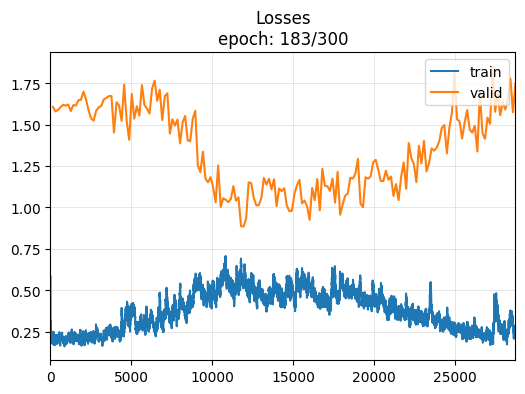

INFO:__main__:Feet 300 cycles tooth


epoch,train_loss,valid_loss,accuracy,time
0,0.691622,0.691622,0.511905,00:39
1,0.690693,0.691460,0.500000,00:39
2,0.692250,0.691035,0.535714,00:40
3,0.691046,0.691323,0.523810,00:39
4,0.691883,0.690846,0.523810,00:39
5,0.690739,0.690934,0.535714,00:39
6,0.693535,0.690674,0.535714,00:39
7,0.692838,0.690340,0.547619,00:39
8,0.694129,0.689717,0.571429,00:39
9,0.688049,0.690400,0.535714,00:39


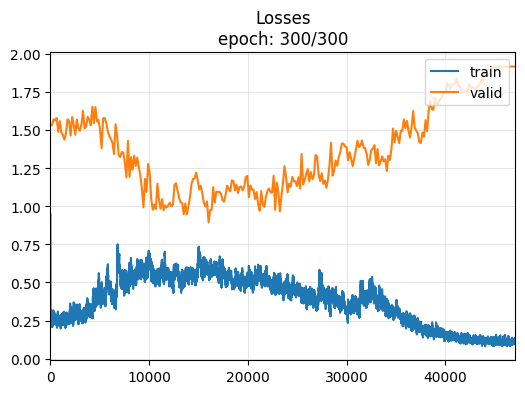

INFO:__main__:Feet 300 cycles drift


epoch,train_loss,valid_loss,accuracy,time
0,0.688405,0.681586,0.666667,00:40
1,0.675305,0.672879,0.702381,00:39
2,0.667834,0.662855,0.714286,00:40
3,0.651278,0.654215,0.750000,00:40
4,0.655426,0.642677,0.726190,00:39
5,0.659032,0.632403,0.738095,00:40
6,0.669866,0.619721,0.761905,00:40
7,0.602176,0.599585,0.773810,00:40
8,0.596404,0.535635,0.821429,00:39
9,0.430066,0.420551,0.869048,00:39


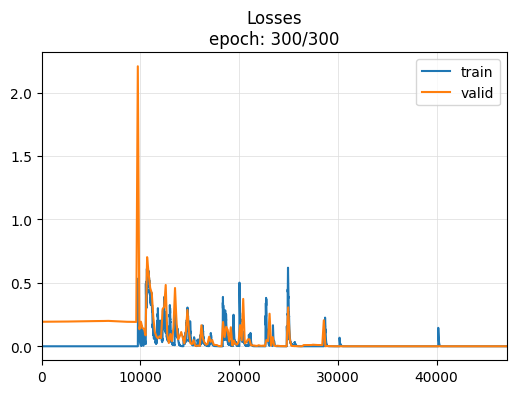

INFO:__main__:Save learners as stage1
INFO:__main__:Tooth plot metrics, model: LSTM


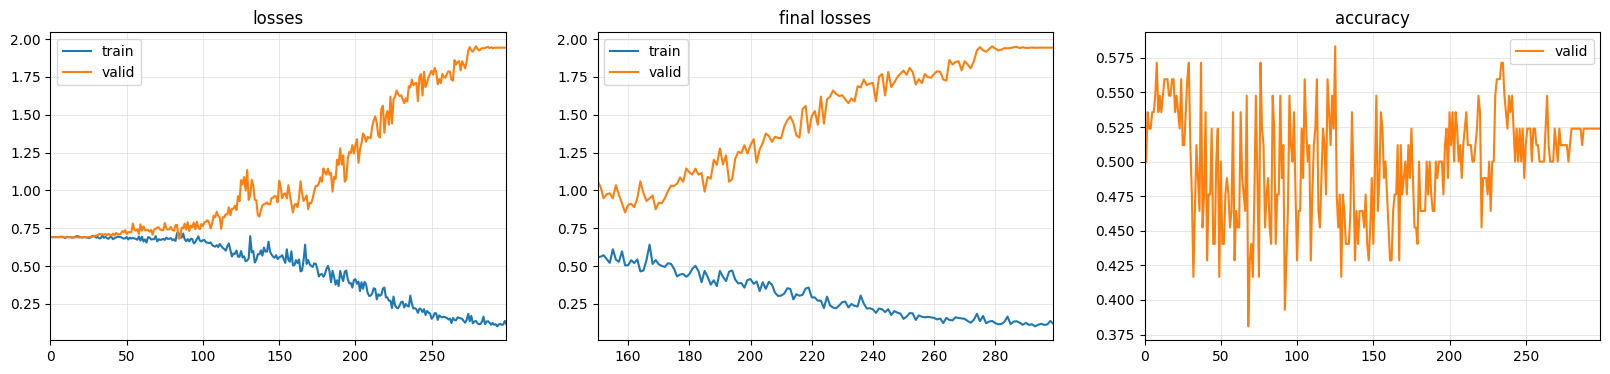

INFO:__main__:Shaft plot metrics, model: LSTM


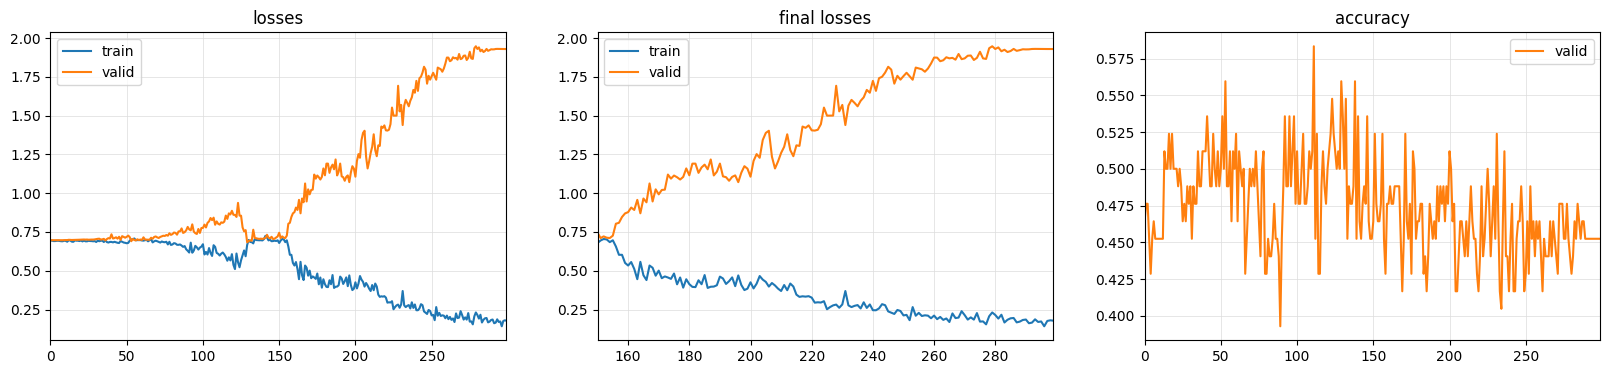

INFO:__main__:Drift plot metrics, model: LSTM


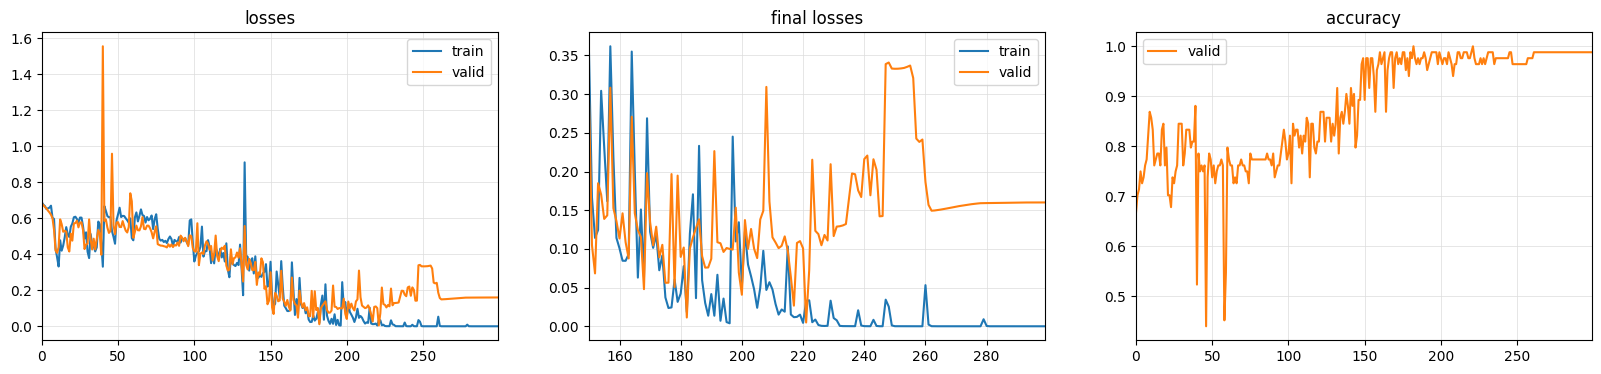

INFO:__main__:Confusion matrixes for each model


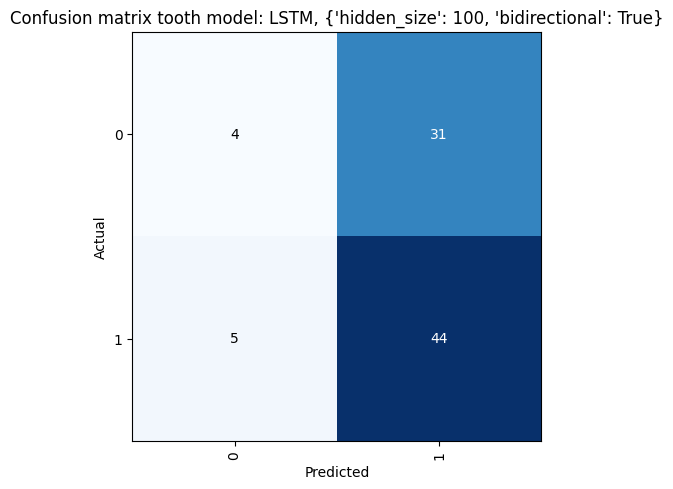

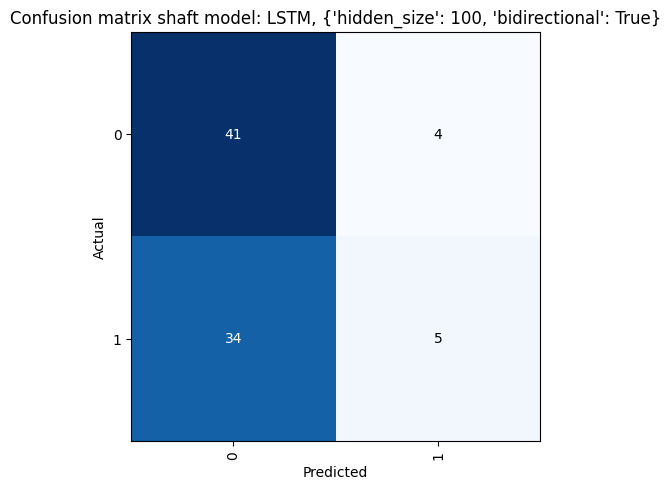

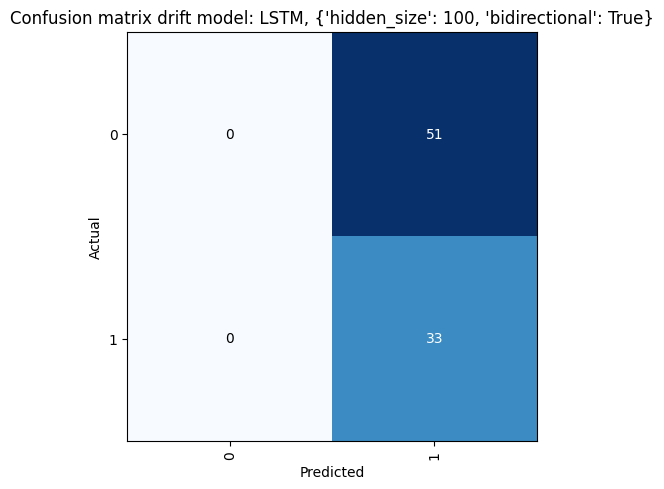

INFO:__main__:Predictions on validation data:


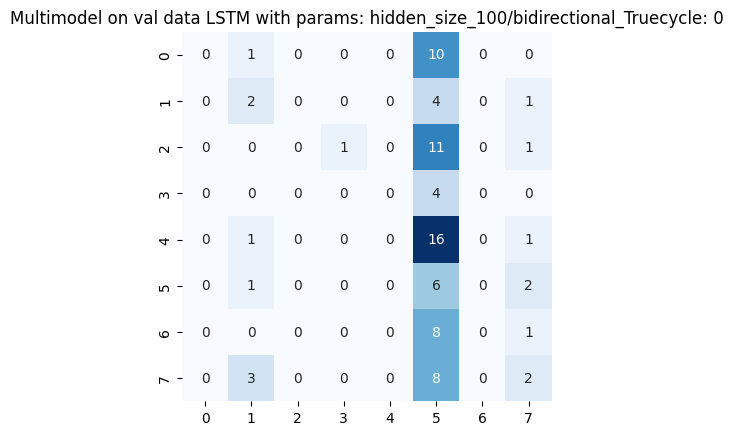

INFO:__main__:accuracy:   0.119048
INFO:__main__:recall:   0.138278
INFO:__main__:precision:   0.073694
INFO:__main__:jaccard:   0.043103
INFO:__main__:Predictions on test data:


INFO:__main__:accuracy:   0.095238
INFO:__main__:recall:   0.083333
INFO:__main__:precision:   0.012500
INFO:__main__:jaccard:   0.011905


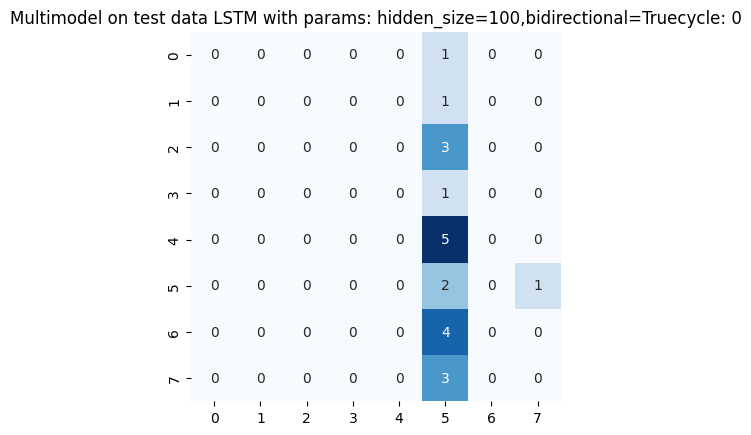

INFO:__main__:Fitting 1 cycle:
INFO:__main__:Feet 300 cycles shaft


epoch,train_loss,valid_loss,accuracy,time
0,1.715218,1.866162,0.535714,00:38
1,1.569277,1.299668,0.547619,00:38
2,1.142622,1.189301,0.547619,00:38
3,0.961686,1.022455,0.511905,00:38
4,0.955034,1.131184,0.511905,00:39
5,1.063523,1.173734,0.476190,00:39
6,1.127010,1.049079,0.511905,00:39
7,1.025142,1.116218,0.428571,00:38
8,0.987902,1.042690,0.440476,00:39
9,1.043246,1.112559,0.428571,00:39


INFO:__main__:Feet 300 cycles tooth


epoch,train_loss,valid_loss,accuracy,time
0,2.381109,1.952289,0.523810,00:39
1,1.916096,1.738150,0.523810,00:39
2,1.815809,1.813359,0.500000,00:39
3,1.504344,1.613098,0.464286,00:39
4,1.377066,1.438092,0.535714,00:40
5,1.210746,1.300228,0.535714,00:39
6,1.183005,1.215428,0.500000,00:39
7,1.054614,1.260482,0.511905,00:39
8,0.992861,1.306119,0.452381,00:39
9,1.072059,1.277625,0.464286,00:39


INFO:__main__:Feet 300 cycles drift


epoch,train_loss,valid_loss,accuracy,time
0,2.197977,2.171520,0.404762,00:39
1,1.472457,1.692822,0.523810,00:40
2,1.166343,1.455476,0.654762,00:40
3,1.060363,1.261665,0.726190,00:40
4,1.023815,1.089842,0.690476,00:40
5,0.832537,0.941802,0.690476,00:40
6,0.732809,0.817583,0.690476,00:40
7,0.663084,0.751175,0.690476,00:40
8,0.633569,0.672842,0.702381,00:40
9,0.571483,0.679894,0.738095,00:40


INFO:__main__:Save learners as stage1
INFO:__main__:Tooth plot metrics, model: LSTM


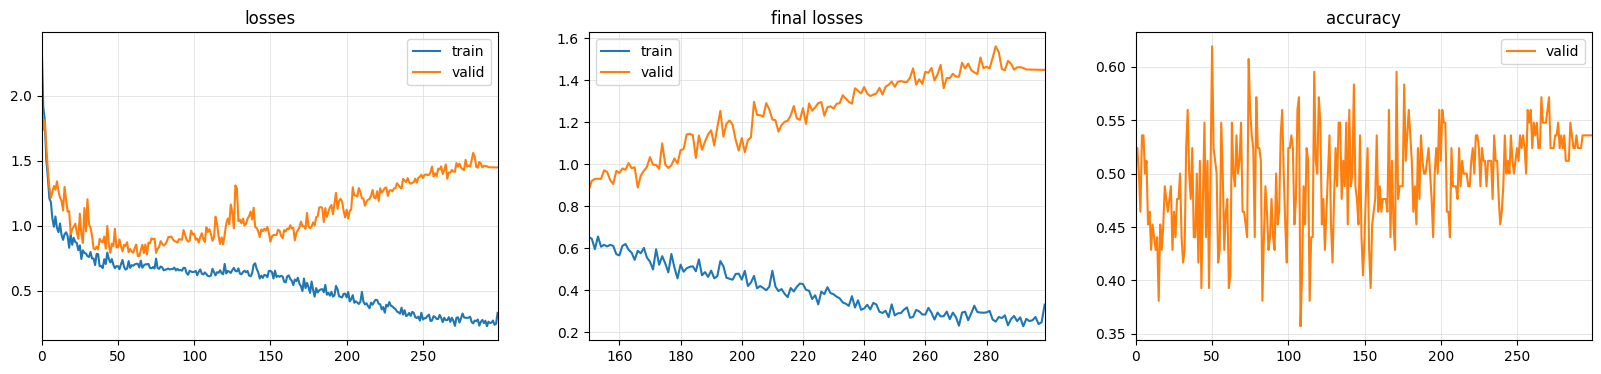

INFO:__main__:Shaft plot metrics, model: LSTM


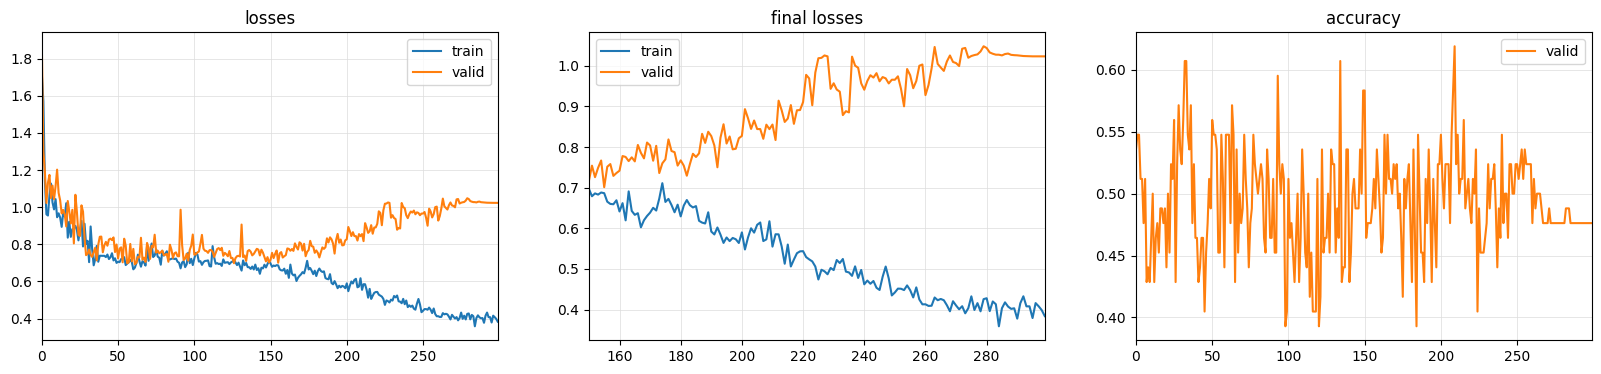

INFO:__main__:Drift plot metrics, model: LSTM


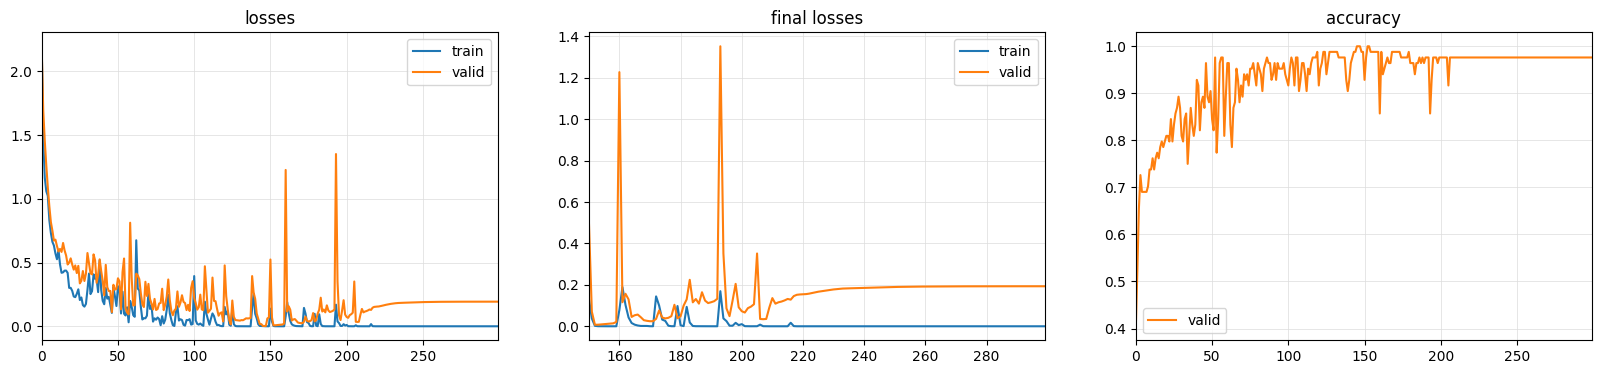

INFO:__main__:Confusion matrixes for each model


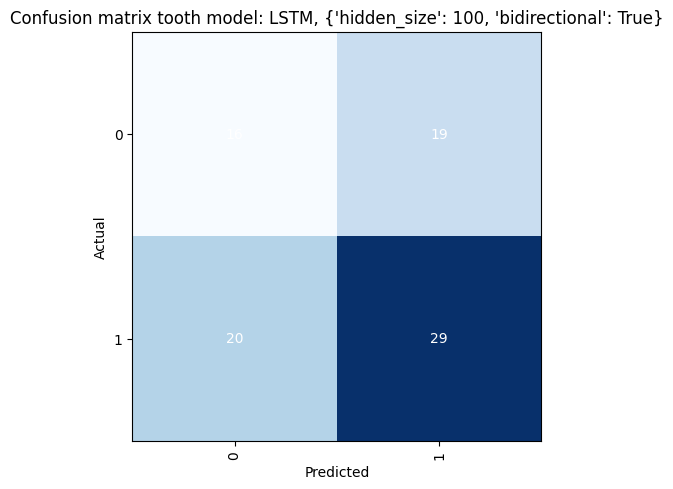

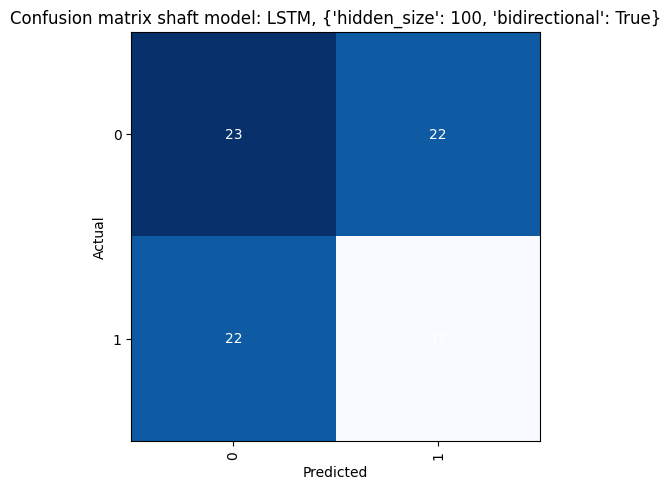

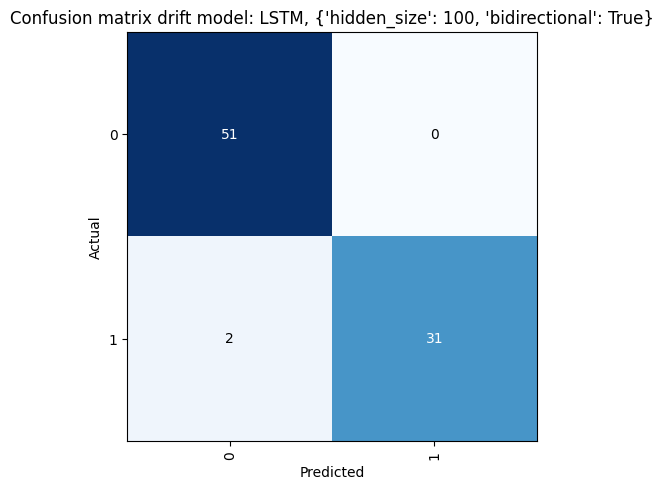

INFO:__main__:Predictions on validation data:


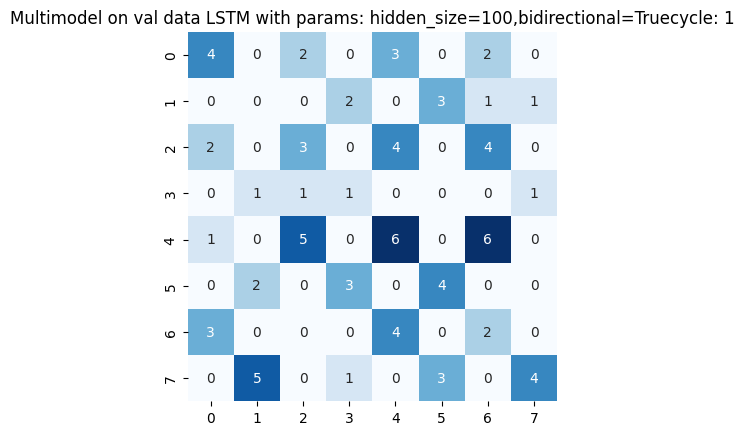

INFO:__main__:accuracy:   0.285714
INFO:__main__:recall:   0.269012
INFO:__main__:precision:   0.296066
INFO:__main__:jaccard:   0.163661
INFO:__main__:Predictions on test data:


INFO:__main__:accuracy:   0.190476
INFO:__main__:recall:   0.222917
INFO:__main__:precision:   0.181250
INFO:__main__:jaccard:   0.125496


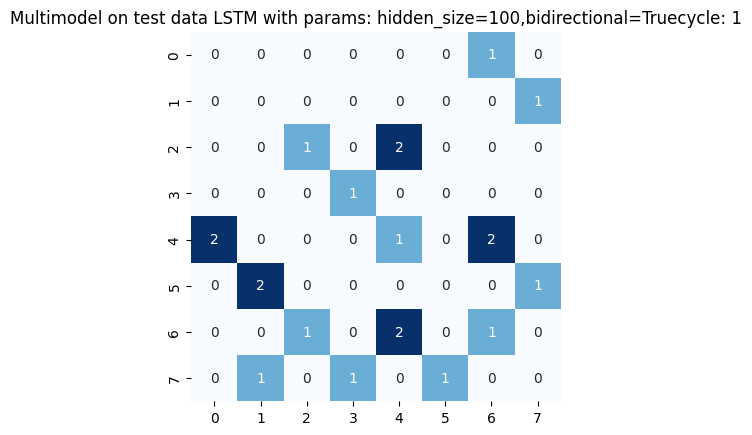

INFO:__main__:Fitting 2 cycle:
INFO:__main__:Feet 300 cycles shaft


epoch,train_loss,valid_loss,accuracy,time
0,0.393705,1.019544,0.488095,00:38
1,0.412378,1.038675,0.488095,00:38
2,0.392960,1.061716,0.476190,00:38
3,0.409760,1.053315,0.476190,00:38
4,0.435272,1.031790,0.476190,00:38
5,0.410190,0.999354,0.488095,00:38
6,0.401033,0.998603,0.500000,00:38
7,0.392740,1.014799,0.488095,00:38
8,0.405947,1.073475,0.488095,00:38
9,0.421957,1.009672,0.500000,00:38


INFO:__main__:Feet 300 cycles tooth


epoch,train_loss,valid_loss,accuracy,time
0,0.261654,1.532802,0.488095,00:39
1,0.259771,1.571124,0.523810,00:39
2,0.245318,1.561469,0.511905,00:39
3,0.244151,1.579190,0.500000,00:39
4,0.266033,1.488218,0.535714,00:39
5,0.265947,1.558696,0.559524,00:39
6,0.264967,1.485050,0.559524,00:39
7,0.249629,1.468194,0.559524,00:39
8,0.237377,1.436847,0.559524,00:39
9,0.273833,1.478936,0.559524,00:40


INFO:__main__:Feet 300 cycles drift


epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.193282,0.976190,00:40
1,0.000000,0.193340,0.976190,00:40
2,0.000000,0.193413,0.976190,00:40
3,0.000000,0.193493,0.976190,00:40
4,0.000000,0.193558,0.976190,00:40
5,0.000000,0.193647,0.976190,00:40
6,0.000000,0.193780,0.976190,00:39
7,0.000000,0.193871,0.976190,00:40
8,0.000000,0.193963,0.976190,00:40
9,0.000000,0.194064,0.976190,00:40


INFO:__main__:Save learners as stage1
INFO:__main__:Tooth plot metrics, model: LSTM


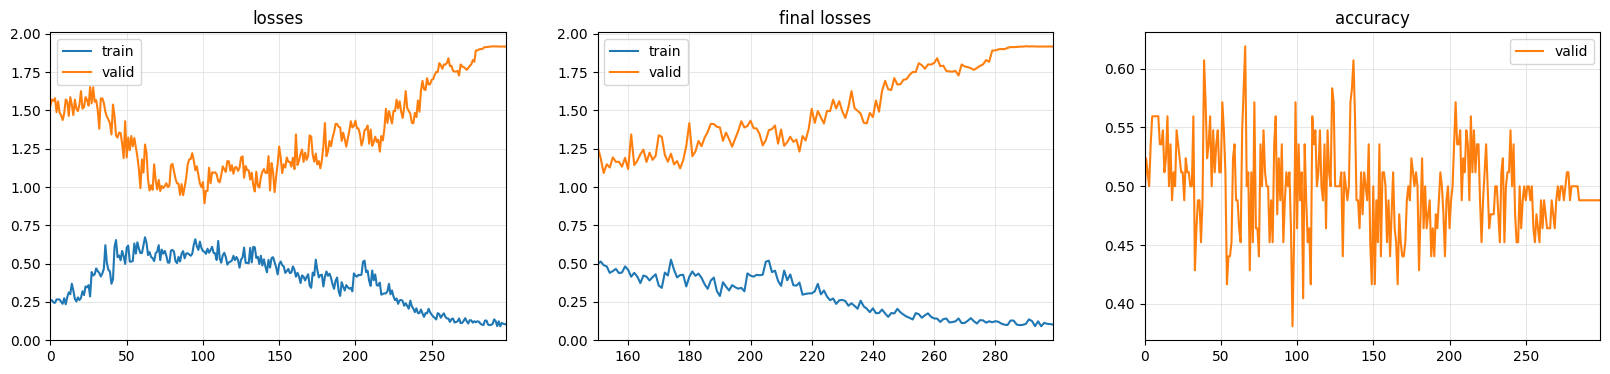

INFO:__main__:Shaft plot metrics, model: LSTM


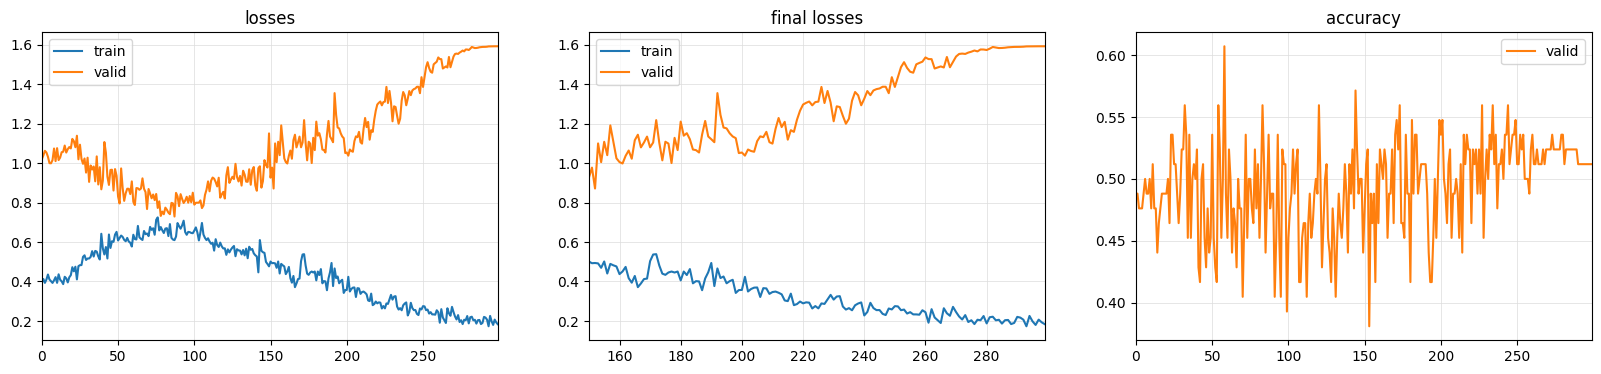

INFO:__main__:Drift plot metrics, model: LSTM


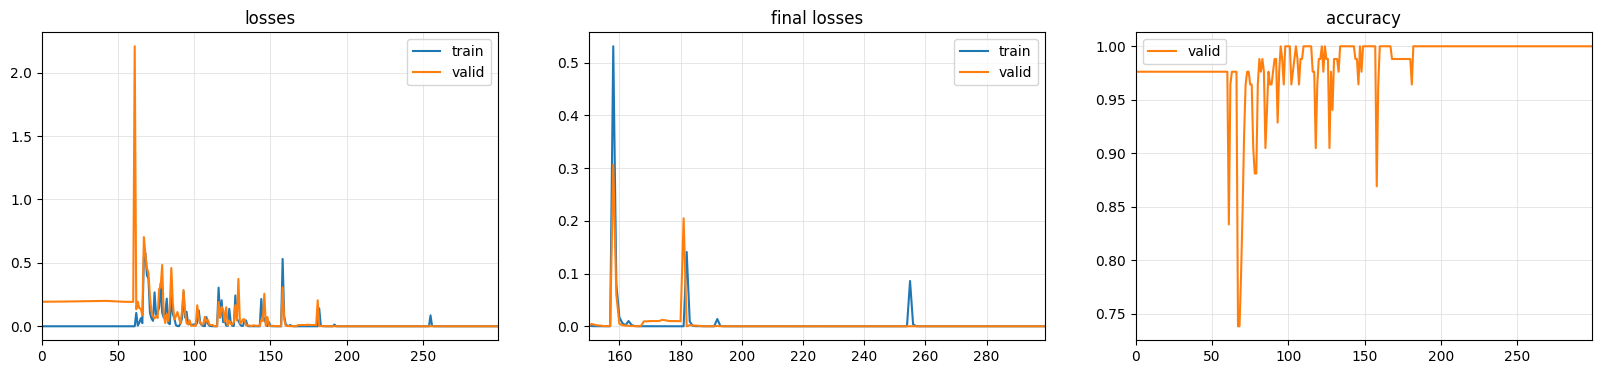

INFO:__main__:Confusion matrixes for each model


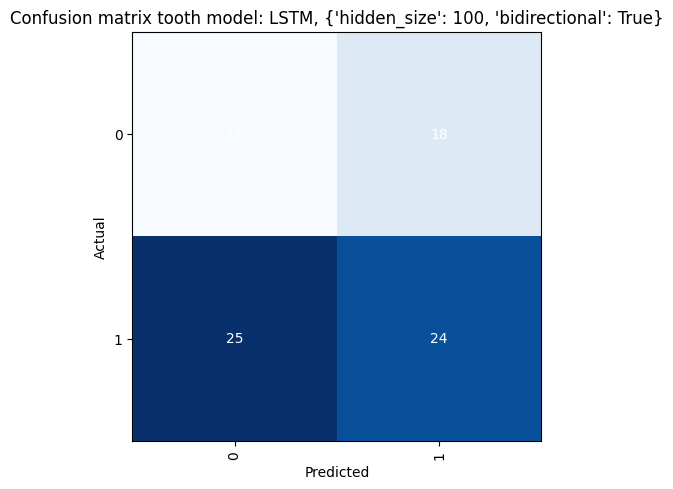

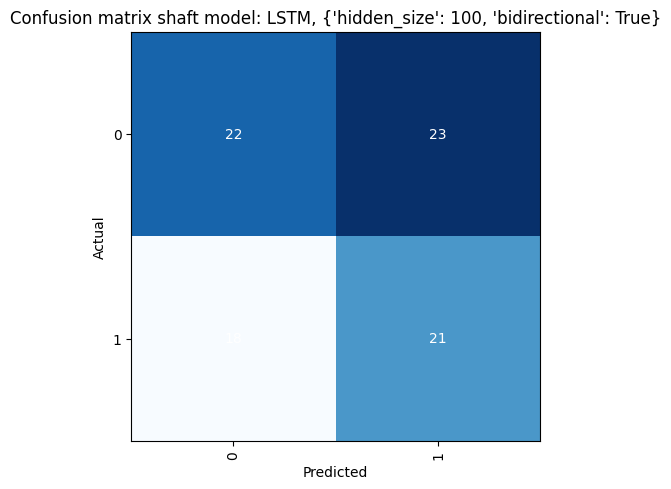

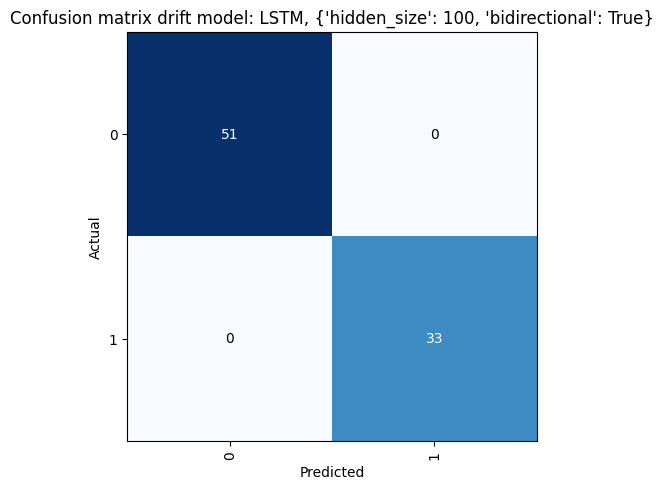

INFO:__main__:Predictions on validation data:


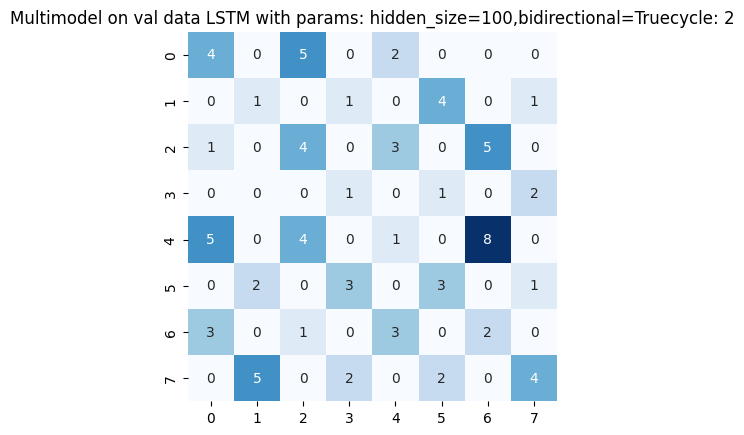

INFO:__main__:accuracy:   0.238095
INFO:__main__:recall:   0.247874
INFO:__main__:precision:   0.238214
INFO:__main__:jaccard:   0.137188
INFO:__main__:Predictions on test data:


INFO:__main__:accuracy:   0.285714
INFO:__main__:recall:   0.302083
INFO:__main__:precision:   0.276042
INFO:__main__:jaccard:   0.156250


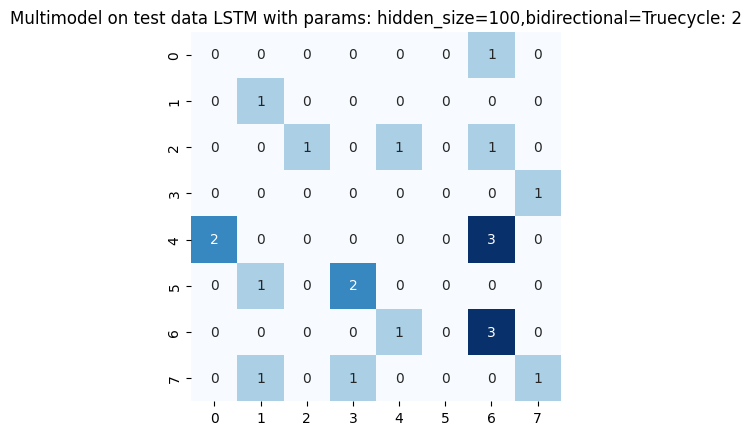

INFO:__main__:Fitting 3 cycle:
INFO:__main__:Feet 300 cycles shaft


epoch,train_loss,valid_loss,accuracy,time
0,0.188246,1.606825,0.511905,00:38
1,0.212036,1.580042,0.523810,00:39
2,0.228306,1.590132,0.523810,00:39
3,0.216817,1.606354,0.511905,00:39
4,0.188200,1.620627,0.535714,00:39
5,0.218336,1.614927,0.500000,00:39
6,0.235166,1.621418,0.511905,00:39
7,0.208652,1.582451,0.511905,00:39
8,0.196117,1.617919,0.511905,00:39
9,0.204663,1.615940,0.511905,00:39


In [57]:
# Train and evaluate models in a loop
for model_dict in models:
    model_name = model_dict['name']
    model_class = model_dict['model']
    model_params = model_dict['params']

    logger.info(f'Training {model_name}...')
    for params in model_params:
        folder_to_save = folder_to_save_base + '/' + model_name
        logger.info(f'With parameters: {params}')
        model = one_model_of_multiple(model_name, X, Y, resolution, batch_size,
                                valid_size, test_size, **params)
        params_string = '/'.join(f'{k}_{v}' for k, v in params.items())
        folder_to_save += '/' + params_string
        logger.info(f'Folder to save: {folder_to_save}')
        # try:
        for cycle in range(cycles):
            logger.info(f'Fitting {cycle} cycle:')
            model.fit_one_cycle()
            model.save_all(folder_to_save)

            logger.info(f'Predictions on validation data:')
            val_targets, val_preds = model.get_preds()
            conf_mat = skm.confusion_matrix(val_targets, val_preds)
            string_title = "Multimodel on val data " + model_name + " with params: " + params_string + "cycle: " + str(cycle) 
            sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False).set_title(string_title)
            plt.show()
            
            logger.info(f'accuracy: {skm.accuracy_score(val_targets, val_preds):10.6f}')
            logger.info(f'recall: {skm.recall_score(val_targets, val_preds, average="macro"):10.6f}')
            logger.info(f'precision: {skm.precision_score(val_targets, val_preds, average="macro"):10.6f}')
            logger.info(f'jaccard: {skm.jaccard_score(val_targets, val_preds, average="macro"):10.6f}')

            logger.info(f'Predictions on test data:')
            test_targets, test_preds = model.get_preds_test()
            logger.info(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
            logger.info(f'recall: {skm.recall_score(test_targets, test_preds, average="macro"):10.6f}')
            logger.info(f'precision: {skm.precision_score(test_targets, test_preds, average="macro"):10.6f}')
            logger.info(f'jaccard: {skm.jaccard_score(test_targets, test_preds, average="macro"):10.6f}')

            params_string = ",".join(f"{key}={value}" for key, value in params.items())
            string_title = "Multimodel on test data " + model_name + " with params: " + params_string + "cycle: " + str(cycle) 
            conf_mat = skm.confusion_matrix(test_targets, test_preds)
            
            sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False).set_title(string_title)
            plt.show()
        # except Exception as e:
        #     logger.error("Except accured, cannot fit this model")
        #     logger.error("ERROR : "+str(e))
        #     pass